In [60]:
import pickle
import pandas as pd
import numpy as np
import scipy.stats
import statsmodels.api as sm
import statsmodels.tsa as tsa
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import seaborn as sns
import math
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_val_score
import pdb

In [69]:
def read_pickle(path):
    
    input_file = open(path,'rb')
    variable = pickle.load(input_file)
    input_file.close()
    return(variable)

def downsample(df, downsample_step = 10):
    
    # Downsample
    df['downsample'] = df['time_period'] % downsample_step
    df = df[df['downsample'] == 0]
    
    return(df)

In [84]:
# Read in data
data = read_pickle('../data/watch/processed_data/train_df.pkl')

# Downsample, we don't need that many observations
data = downsample(data, downsample_step = 5)
len(data)

484378

In [85]:
x = data.drop('is_exercise', axis = 1)
y = data['is_exercise']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [86]:
#Plot ROC Curve
def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
#Plot basic diagnostics
def classification_diagnostics(model, x, y, standardize = True, classifier = True):
    
    fig, axs = plt.subplots(nrows = 1, ncols=2, figsize = (15,4))
    
    if classifier == True:
        
        y_hat = model.predict_proba(x)[:, 1]
        residuals = y - y_hat
        std_error = math.sqrt(np.var(residuals))
        std_residuals = residuals/std_error
        
    else:
        
        y_hat = model.predict(x)
        residuals = y_hat - y
        std_error = math.sqrt(np.var(residuals))
        std_residuals = residuals/std_error
        
    #Residual vs Fitted Plot
    sns.regplot(y_hat, 
                std_residuals, 
                lowess=True,
                line_kws={'color': 'red', 'lw': 1, 'alpha': 1},
                ax = axs[0])
    
    #Histogram of residuals
    sns.distplot(std_residuals, 
                hist=True,
                ax = axs[1])
    
    #Labels
    axs[0].set(xlabel="Fitted Values", 
                ylabel="Pearson's Standardized Residuals", 
                title = 'Residual vs Fitted')
    
    axs[1].set(xlabel="Fitted Values", 
                ylabel="Frequency", 
                title = "Residuals Histogram")

In [100]:
class FeatureSelector(BaseEstimator, TransformerMixin):

    def __init__(self, select_features):
        self.select_features = select_features
    
    def fit(self, x_df, y=None):
        return self
    
    def transform(self, x_df, y=None):
        select_features = self.select_features
        x_df = x_df[select_features]
        return(x_df)

    
class ContinuousFeatureEngineering(BaseEstimator, TransformerMixin):
    
    # Initiate class
    def __init__(self, window):
        self.window = window
        return None
        
    # We don't need to fit anything, so leave this as is
    def fit(self, df, y=None):
        return self
    
    # Perform our feature transformations
    def transform(self, df, y=None):
        
        x_df = df.copy(deep = True)
        
        col_names = x_df.columns
        
        # Time-Series transformations
        for col in col_names:
            
            # Box-Cox estimation
            x_df[col] = x_df[col] - min(x_df[col]) + 0.0001
            y, fitted_lambda = scipy.stats.boxcox(x_df[col],lmbda = None)
        
            # First difference, make first element nan, loss from differencing
            y = np.append([np.nan], np.diff(y, n=1))
            x_df[col] = y
        
        # Add volatility columns
        for col in col_names:
            x_df[col + '_vol'] = x_df[col].rolling(self.window).std()
        
        # Add moving average columns
        for col in col_names:
            x_df[col + '_ma'] = x_df[col].rolling(self.window).mean()
        
        # Fill nan values with mean
        x_df = x_df.fillna(x_df.mean())
        
        # Standardize data
        standard_scaler = preprocessing.StandardScaler()
        x_df = standard_scaler.fit_transform(x_df)
        
        return x_df

In [101]:
# ----Feature Pipeline ----#
num_attributes = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']
window = 50

numerical_pipeline = Pipeline([

    ('FeatureSelector', FeatureSelector(num_attributes)),
    ('FeatureEngineering', ContinuousFeatureEngineering(window))
])

In [102]:
check_pca = numerical_pipeline.fit_transform(x_train)

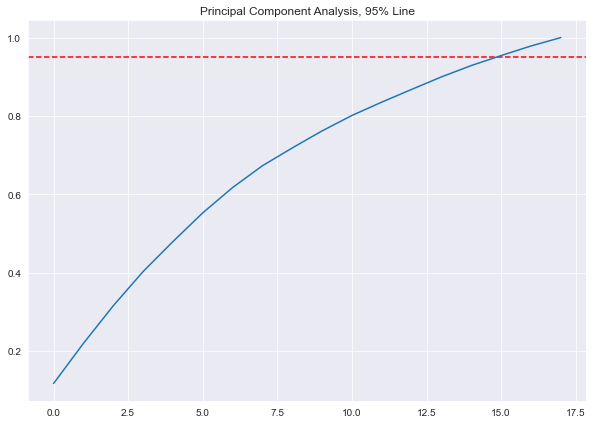

In [109]:
#Hmm seems like the features are quite different, let's not apply PCA for now
pca = PCA() #use all components for now
x_pca = pca.fit_transform(check_pca)
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(10, 7))
ax.set_title('Principal Component Analysis, 95% Line')
ax.axhline(0.95, ls='--', color = 'red')
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [110]:
feature_pipeline = FeatureUnion([
        ('numerical_pipeline', numerical_pipeline)
    ])

## Test some algorithms

In [111]:
processed_x_train = feature_pipeline.fit_transform(x_train)
proccessed_x_test = feature_pipeline.fit_transform(x_test)

Logistic Regression

In [112]:
log_model = LogisticRegression()
log_model.fit(processed_x_train, y_train)
scores = cross_val_score(log_model, processed_x_train, y_train,
                        scoring = "roc_auc", cv = 10)
print('CV AUC Scores: ', scores)
print('Mean CV AUC Scores: ', np.mean(scores))

CV AUC Scores:  [0.6894047  0.67963689 0.68032382 0.68874934 0.6844411  0.68337725
 0.69302413 0.69129808 0.68892053 0.69007576]
Mean CV AUC Scores:  0.6869251605540981


In [125]:
predict = log_model.predict(proccessed_x_test)
roc_auc_score(predict, y_test)

0.6865312156322877

CART Classifier

In [113]:
cart_model = DecisionTreeClassifier(min_samples_leaf = 30) #blanket default, to avoid 1 observation per leaf
cart_model.fit(processed_x_train, y_train)

scores = cross_val_score(cart_model, processed_x_train, y_train,
                        scoring = "roc_auc", cv = 10)
print('CV AUC Scores: ', scores)
print('Mean CV AUC Scores: ', np.mean(scores))

CV AUC Scores:  [0.83455949 0.83539533 0.83127895 0.83622092 0.83467801 0.83582839
 0.83753394 0.83489763 0.83339751 0.83452795]
Mean CV AUC Scores:  0.8348318122461234


In [124]:
predict = cart_model.predict(proccessed_x_test)
roc_auc_score(predict, y_test)

0.7551572491456423

In [116]:
rand_forest_model = RandomForestClassifier(min_samples_leaf = 30,verbose=3,n_jobs=-1)
rand_forest_model.fit(processed_x_train, y_train)

#scores = cross_val_score(rand_forest_model, processed_x_train, y_train,
#                        scoring = "roc_auc", cv = 10)
#print('CV AUC Scores: ', scores)
#print('Mean CV AUC Scores: ', np.mean(scores))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100building tree 4 of 100building tree 5 of 100
building tree 6 of 100

building tree 7 of 100building tree 8 of 100


building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100building tree 15 of 100

building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.8s


building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100building tree 36 of 100

building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   50.3s finished


RandomForestClassifier(min_samples_leaf=30, n_jobs=-1, verbose=3)

In [123]:
#This is on the unseen test set, we can do cross val as well and that'll be about 5 mins.
predict = rand_forest_model.predict(proccessed_x_test)
roc_auc_score(predict, y_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished


0.8004646515960852